Анализ мощности различных тестов:
https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f


# Доверительные интервалы в параметрических тестах

Для всех метрик в параметрических тестах схема построения доверительных интервалов одинакова:

1. Вычисляем метрику (конверсия, ARPU, ARPPU, число целевых событий)
2. В зависимости от метрики вычисляем стандартную ошибку (SE)
3. В зависимости от числа потенциальных вариантов сравнения
выбираем квантиль распределения статистики теста


## Конверсия

p $\pm$ $z_{\alpha} * \sqrt{\frac {p * (1 - p)}{n} }$

Здесь p - вероятность конверсии

$\sqrt{\frac {p * (1 - p)}{n} }$ - SE - стандартная ошибка в тесте

$z_{\alpha}$ - квантиль стандартного нормального распределения. Например, для уровня доверия 95% мы ищем
97.5% квантиль и он равен 1.96.

## Разница конверсий

diff_p $\pm$ $z_{\alpha} * \sqrt{\frac {p_1 * (1 - p_1)}{n_1} + \frac{p_2 * (1-p_2)}{n_2} }$

## ARPU, ARPPU

***Наблюдения независимы (юзеры из разных выборок не повторяются и не влияют на поведение друг друга)***

***в предположении, что у нас много юзеров и мы пользуемся ЦПТ,
которая нам говорит о нормальности средних***



### Предпосылки:

#### ДИСПЕРСИИ ОДИНАКОВЫ

Для **одного среднего**:

arpu $\pm t_{\alpha} * SE$

$SE = \sqrt{\sigma^2 / n}$

Для **разницы средних**:
SE= $\sqrt{ \frac{\sigma_1^2} {n_1} + \frac{\sigma_2 ^ 2}{n_2} }$

Оптимальное значение числа юзеров ищем по этой формуле:

$
n = (\frac {np.sqrt(2\sigma^2) * (z_\beta + z_\alpha)} {mde})^2
$

$mde$ - maximum detectable effect

$z_{beta}$ - квантиль стандартного нормального распределения уровня beta (ошибка второго рода)

$z_{alpha}$ - квантиль стандартного нормального распределения уровня alpha (ошибка первого рода)

In [1]:
import statsmodels.stats.api as sms
import numpy as np
# Создадим выборки из теоретических распределений с разными мат ожиданиями
means1 = np.random.normal(loc=1, scale=2, size=5000)
means2 = np.random.normal(loc=1.15, scale=2, size=5000)
cm = sms.CompareMeans(sms.DescrStatsW(means1), sms.DescrStatsW(means2))
print(f"Доверительный интервал для разницы: {cm.tconfint_diff(usevar='unequal')}")

ci1 = (means1.mean() - 1.96 * means1.std() / np.sqrt(means1.shape[0]),
       means1.mean() + 1.96 * means1.std() / np.sqrt(means1.shape[0]))
ci2 = (means2.mean() - 1.96 * means2.std() / np.sqrt(means2.shape[0]),
       means2.mean() + 1.96 * means2.std() / np.sqrt(means2.shape[0]))
print(f"Средние: {means1.mean()}, {means2.mean()}")
print("Доверительные интервалы для средних отдельно: \n")
print(ci1)
print(ci2)

Доверительный интервал для разницы: (-0.23179967496231826, -0.07499615986769367)
Средние: 1.0224951257628936, 1.1758930431778993
Доверительные интервалы для средних отдельно: 

(0.9676491485765392, 1.077341102949248)
(1.1198907014914796, 1.231895384864319)


***Метод построения доверительных интервалов для каждого варианта имеет более низкую мощность!***

*Сейчас мы это попытаемся проиллюстрировать.*

### Процедура 1:

1. Собираем выборки $X_1, \ldots, X_n$ и $Y_1, \ldots, Y_n$;
2. Находим значение статистики

$
z_{obs} = \frac{\bar x - \bar y}{\sqrt{\frac{s_x^2}{n_x} + \frac{s_y^2}{n_y}}};
$

3. Говорим, что по ЦПТ $z_{obs} \overset{asy}{\sim} N(0,1);$
4. Находим критическое значение $z_{1 - \frac{\alpha}{2}}$ (для 95% уровня доверия - это 1.96);
5. Если мы видим, что $|z_{obs}| <  z_{1 - \frac{\alpha}{2}}$, мы говорим, что гипотеза не отвергается.

Ту же саму гипотезу можно попробовать проверить с помощью другого алгоритма, основанного на доверительных интервалах.

### Процедура 2:

1. Собираем выборки $X_1, \ldots, X_n$ и $Y_1, \ldots, Y_n$;
2. Находим $\bar x$ и $\bar y$;
3. Пользуясь ЦПТ и зная, что $\bar x \overset{asy}{\sim} N \left(\mu_1,\frac{s^2_x}{n_x} \right)$ и $\bar y \overset{asy}{\sim} N\left(\mu_2,\frac{s^2_y}{n_y}\right)$ строим для $\mu_1$ и $\mu_2$ доверительные интервалы;
4. Если доверительные интервалы пересеклись, говорим, что гипотеза не отвергается.

Вроде бы вторая процедура выглядит довольно естественно, однако ей никто не пользуется. Дело в том, что для одинаковых ошибок первого рода, $\alpha$, ошибка второго рода, $\beta$, для процедуры, основанной на доверительных интервалах, окажется выше. Задание состоит в том, чтобы это увидеть.

> Для простоты будем дальше предполагать, что $\bar x > \bar y$. Также будем считать, что обе дисперсии известны и равны единице, $\sigma^2_x = \sigma^2_y = 1$. Объёмы выборок одинаковы, $n_x = n_y = n$.


# Гипотеза о равенстве средних не отвергается, если

$ \frac{\bar{x} - \bar{y}}{\sqrt{\frac{\sigma^2_x}{n_x} + \frac{\sigma^2_y}{n_y}}} < z_{1-\alpha}
\frac{\bar{x} - \bar{y}}{\sqrt{\frac{2}{n}}} < z_{1-\alpha} $

# Найдём ошибку второго рода:

$
\mathbb{P} \left( H_0 \mid H_a \right) = \mathbb{P} \left( \frac{\bar{x} - \bar{y}}{\sqrt{\frac{2}{n}}} < z_{1-\alpha} \mid \mu_1 \ne \mu_2 \right)  =
\mathbb{P} \left( \frac{\bar{x} - \bar{y} - (\mu_1 - \mu_2)}{\sqrt{\frac{2}{n}}} < z_{1-\alpha} - \frac{\mu_1 - \mu_2}{\sqrt{\frac{2}{n}}} \mid \mu_1 \ne \mu_2 \right) =
\Phi \left( z_{1-\alpha} - \frac{\mu_1 - \mu_2}{\sqrt{\frac{2}{n}}} \right)
$

Построим доверительные интервалы для средних:

$
\bar{x} \pm z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} }
\bar{y} \pm z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} }
$

Если доверительные интервалы пересекаются, гипотеза не отвергается, то есть:
$
\bar{x} - z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} } < \bar{y} + z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} } \\
\bar{x} - \bar{y} < 2 \cdot z_{1 - \alpha} \cdot \sqrt{ \frac{1}{n} } \\
\frac{\bar{x} - \bar{y}}{  \sqrt{ \frac{1}{n} } }  < 2 \cdot z_{1 - \alpha} \\
\frac{\bar{x} - \bar{y}}{  \sqrt{ \frac{2}{n} } }  < \sqrt{2} \cdot 2 \cdot z_{1 - \alpha} \\
$

Напомню, что для простоты мы считаем, что $\bar x > \bar y$. Найдём ошибку второго рода:

$
\mathbb{P} \left( H_0 \mid H_a \right)  = \mathbb{P} \left( \frac{\bar{x} - \bar{y} - (\mu_1 - \mu_2)}{\sqrt{\frac{2}{n}}} < \sqrt{2} \cdot 2 \cdot z_{1-\alpha} - \frac{\mu_1 - \mu_2}{\sqrt{\frac{2}{n}}} \mid \mu_1 \ne \mu_2 \right) = \Phi \left( \sqrt{2} \cdot 2 \cdot z_{1-\alpha} - \frac{\mu_1 - \mu_2}{\sqrt{\frac{2}{n}}} \right)
$


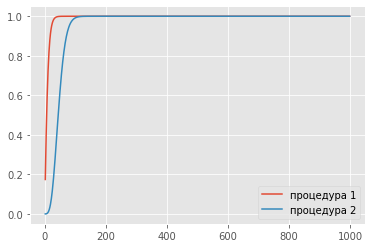

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('ggplot')
%matplotlib inline


def power_1(n_obs, alpha=0.05, mu1=4, mu2=5, sigma=1):
    z_crit = stats.norm().ppf(1 - alpha)
    a = z_crit - (mu2 - mu1)/np.sqrt(2 * sigma/n_obs)
    return 1 - stats.norm().cdf(a)

def power_2(n_obs, alpha=0.05, mu1=4, mu2=5, sigma=1):
    z_crit = stats.norm().ppf(1 - alpha)
    a = 2*np.sqrt(2)*z_crit - (mu2 - mu1)/np.sqrt(2 * sigma/n_obs)
    return 1 - stats.norm().cdf(a)

obs = np.arange(1, 1000)

plt.plot(obs, power_1(obs), label='процедура 1')
plt.plot(obs, power_2(obs), label='процедура 2')
plt.legend( );

Теперь проведем много тестов (с поправкой Сидака) и посмотрим,
в скольких случаях мы сможем обнаружить эффект при помощи двух процедур.
Поправка Сидака: сравниваем p-value или строим доверительные интервалы для уровня значимости:
$
\alpha_{correction} = 1 - (1 - \alpha)^{1/m}
$


In [96]:
def get_size(mean1, mean2, alpha, beta, sd):
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta =  stats.norm.ppf(1 - beta)
    n = (np.sqrt(2) * sd * (z_beta + z_alpha) / (mean1 - mean2))**2
    return np.int16(n)

def conf_int_calc_type1(data, alpha, sd):
    """
    Calculate confident intervals for two datasets for significance level in the first case
    :param data: dataset (nrow - observation, ncol - number of variants)
    :param sd: standard deviation of population
    :param alpha: significance level
    :return: confident interval (tuple)
    """
    z_crit = stats.norm().ppf(1 - alpha)
    n = data.shape[0]
    mean1, mean2 = data['1'].mean(), data['2'].mean()
    sd1, sd2 = sd, sd

    ci1 =  (mean1 - z_crit * sd1 / np.sqrt(n),
            mean1 + z_crit * sd1 / np.sqrt(n))
    ci2 =  (mean2 - z_crit * sd2 / np.sqrt(n),
            mean2 + z_crit * sd2 / np.sqrt(n))

    if ci1[0] > ci2[1]:
        return "средние не равны"
    else:
        return "средние равны"

def conf_int_calc_type2(data, alpha, sd):
    z_crit = stats.norm().ppf(1 - alpha/2)
    n = data.shape[0]
    mean1, mean2 = data['1'].mean(), data['2'].mean()

    ci = (mean1 - mean2 - np.sqrt((2 * sd**2)/n) * z_crit,
          mean1 - mean2 + np.sqrt((2 * sd**2)/n) * z_crit)
    if (ci[0] < 0) & (ci[1] > 0):
        return "средние равны"
    else:
        return "средние не равны"

from collections import Counter
results_dividing = []
results_paired = []
results_p_values_test = []
p_values_list = []
alpha = 0.05
mean1, mean2, sd = 1.5, 1, 5
print(f"Нужно юзеров, чтобы уловить эффект изменения: {get_size(mean1, mean2, 0.05, 0.2, sd=sd)}")
for i in range(1, 1001):
    np.random.seed(i)
    data = pd.DataFrame(columns=list("12"))
    alpha_correction = 1 - (1 - alpha) ** (1/i)
    size = get_size(mean1, mean2, alpha_correction, beta=0.2, sd=sd)
    data['1'] = np.random.normal(loc=mean1, scale=sd, size=size)
    data['2'] = np.random.normal(loc=mean2, scale=sd, size=size)

    results_dividing.append(conf_int_calc_type1(data, alpha_correction, sd=sd))
    results_paired.append(conf_int_calc_type2(data, alpha_correction, sd=sd))
    stat, p = stats.ttest_ind(data['1'], data['2'], equal_var=True)
    p_values_list.append(p)
    if p < alpha_correction:
        results_p_values_test.append("средние не равны")
    else:
        results_p_values_test.append("средние равны")
print(f"Доверительные интервалы для каждого среднего: {Counter(results_dividing)}")
print(f"Доверительные интервалы для разницы: {Counter(results_paired)}")
print(f"Готовый стат тест: {Counter(results_p_values_test)}")


Нужно юзеров, чтобы уловить эффект изменения: 1569
Доверительные интервалы для каждого среднего: Counter({'средние равны': 665, 'средние не равны': 335})
Доверительные интервалы для разницы: Counter({'средние не равны': 836, 'средние равны': 164})
Готовый стат тест: Counter({'средние не равны': 833, 'средние равны': 167})


In [97]:
cm = sms.CompareMeans(sms.DescrStatsW(data['1']), sms.DescrStatsW(data['2']))
print(f"Доверительный интервал для разницы: {cm.tconfint_diff(usevar='pooled')}")

def conf_int_calc_type2(data, alpha, sd):
    z_crit = stats.norm().ppf(1 - alpha/2)
    n = data.shape[0]
    mean1, mean2 = data['1'].mean(), data['2'].mean()

    ci = (mean1 - mean2 - np.sqrt((2 * sd ** 2)/n) * z_crit,
          mean1 - mean2 + np.sqrt((2 * sd ** 2)/n) * z_crit)
    print(ci)
    if (ci[0] < 0) & (ci[1] > 0):
        return "средние равны"
    else:
        return "средние не равны"
conf_int_calc_type2(data, 0.05, sd=5)

Доверительный интервал для разницы: (0.2551996317759111, 0.6589323497410244)
(0.25669377178583397, 0.657438209731102)


'средние не равны'